In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# create a dataframe from the csv file
from src.config import SENTIMENT_ANNOTATIONS_CSV
df = pd.read_csv(SENTIMENT_ANNOTATIONS_CSV)

## Poking Around the Data

### Basics

In [5]:
# What does it look like?
df.head()

,team_id,id,title,entry,data_source,sentiment_output,annotated_sentiment,correct?
0,881,2739024,NaN,When I picked car it was 25 $ when my receipt ...,gplay,NEGATIVE,NEGATIVE,1
1,988,2387246,Target IT systems are less than ideal,"As a disclaimer, I don't think it's the fault ...",Forum,NEGATIVE,NEGATIVE,1
2,881,2739001,NaN,Good,gplay,POSITIVE,POSITIVE,1
3,849,1872388,Jump back to the previous tab? (not with Alt +...,I closed the option that lets to toggle over t...,Reddit,NEGATIVE,NEGATIVE,1
4,881,2708601,NaN,"My driver today was excellent!!! Great Person,...",gplay,POSITIVE,POSITIVE,1


In [6]:
# How many rows and columns?
df.shape

(300, 8)

### Distributions

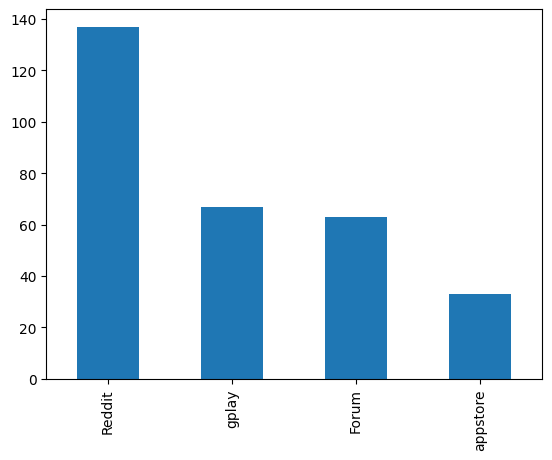

In [7]:
# How much of our data comes from each source?
df["data_source"].value_counts().plot(kind="bar")
plt.show()

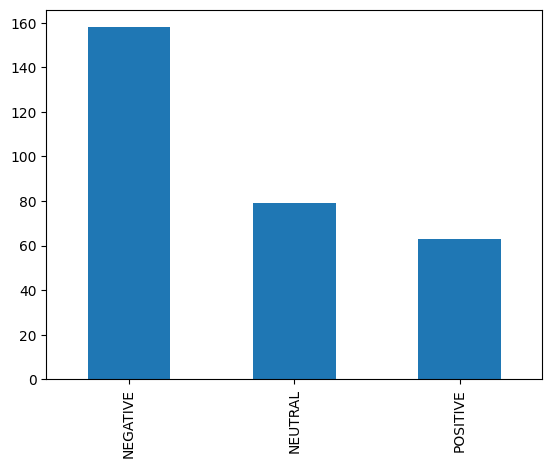

In [8]:
# What's the distribution of sentiment?
df["sentiment_output"].value_counts().plot(kind="bar")
plt.show()

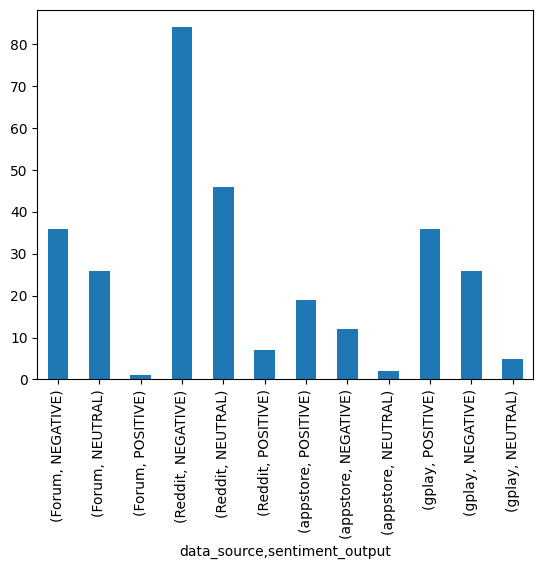

In [9]:
# What is the distribution of sentiment for each data_source?
df.groupby("data_source")["sentiment_output"].value_counts().plot(kind="bar")
plt.show()

### Title and Entry Descriptions

In [10]:
# Okay, so Reddit is full of pessimists, no surprise there.
# The app store and gplay are slightly positive, and have similar distributions.
# What percentage of the titles are NaN?
round(df["title"].isna().sum() / df.shape[0], 2)

0.24

In [11]:
# About 1/4, so probably could use the title to help with sentiment analysis.
# Are there any NaNs in the entry column?
df["entry"].isna().sum()

0

In [12]:
# No, that's good.
# But what is the average length, standard deviation, min, and max of the entry column?
df["entry"].str.len().describe()

count     300.000000
mean      343.896667
std       498.464021
min         1.000000
25%        90.750000
50%       230.500000
75%       422.500000
max      6292.000000
Name: entry, dtype: float64

In [15]:
# Let's import a tokenizer to see the breakdown by tokens instead of characters.
import tiktoken

encoder = "p50k_base"
enc = tiktoken.get_encoding(encoder)

df["entry_enc"] = df["entry"].apply(enc.encode)  # tokenize
df["entry_token_count"] = df["entry_enc"].apply(lambda x: len(x))  # get token count
df["entry_token_count"].describe()  # get stats

count     300.000000
mean       81.700000
std       119.206757
min         1.000000
25%        20.000000
50%        52.000000
75%       101.500000
max      1500.000000
Name: entry_token_count, dtype: float64

In [ ]:
# We'll have to watch out for that max value of 1500, but otherwise the length looks good
# to pass into a transformer model like BERT since the max length is usually 512.

## Baseline Accuracy

In [ ]:
# How accurate is the baseline sentiment analysis model?
df["correct?"].sum() / df.shape[0]

0.69

In [ ]:
# 0.69 isn't bad, but let's get a little more insight into the errors.
from sklearn.metrics import classification_report

print(classification_report(df["sentiment_output"], df["annotated_sentiment"]))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.66      0.72       158
     NEUTRAL       0.45      0.62      0.52        79
    POSITIVE       0.93      0.84      0.88        63

    accuracy                           0.69       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.73      0.69      0.70       300



In [ ]:
# We can see that the model is struggling with the neutral class.
# Let's take a look at some incorrect predictions for the neutral class.
df_neutral = df[df["sentiment_output"] == "NEUTRAL"]
df_neutral_inc = df_neutral[df_neutral["annotated_sentiment"] != "NEUTRAL"]
df_neutral_inc.head()

,team_id,id,title,entry,data_source,sentiment_output,annotated_sentiment,correct?,entry_doc,entry_token_count
10,988,2388030,Spouses and scheduling,From the spouse and family of an employee…. Sc...,Forum,NEUTRAL,NEGATIVE,0,"(From, the, spouse, and, family, of, an, emplo...",95
13,881,2708605,NaN,Lyft drivers now are not only rude but also th...,gplay,NEUTRAL,NEGATIVE,0,"(Lyft, drivers, now, are, not, only, rude, but...",19
25,988,2776302,TL won’t give me breaks,I work up front (usually service desk) and we’...,Reddit,NEUTRAL,NEGATIVE,0,"(I, work, up, front, (, usually, service, desk...",140
55,988,2601491,I really wish guests would stop leaving their ...,Seriously. There's Two trash cans right in fro...,Reddit,NEUTRAL,NEGATIVE,0,"(Seriously, ., There, 's, Two, trash, cans, ri...",115
78,881,2708596,NaN,It's great but in morning it's too much money ...,gplay,NEUTRAL,NEGATIVE,0,"(It, 's, great, but, in, morning, it, 's, too,...",76


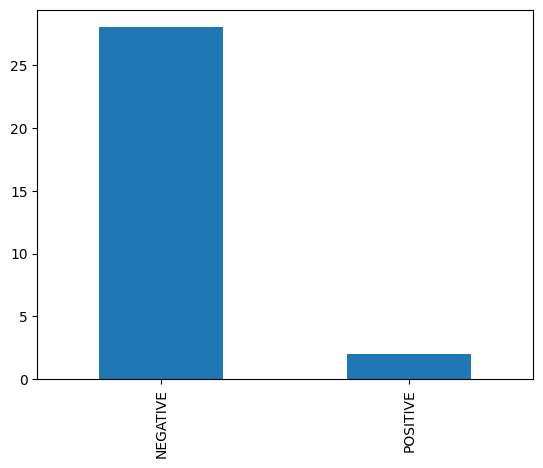

In [ ]:
# So those are all incorrectly labeled as negative.
# What's the distribution of predicted sentiment for the incorrect neutral class?
df_neutral_inc["annotated_sentiment"].value_counts().plot(kind="bar")
plt.show()

In [ ]:
# Okay, so in the incorrect cases, the model is mostly predicting negative.
# Let's take a look at some of the incorrect negative predictions.
for i in range(5):
    print(f"{i+1}. {df_neutral_inc.iloc[i]['entry']}")
    print(f"Predicted: {df_neutral_inc.iloc[i]['annotated_sentiment']}")
    print()

1. From the spouse and family of an employee…. Scheduling appointments more than 17 days out is hard sometimes. Please allow employees a minimum 10 days to request off, and provide an online way to post and accept requests for taking or swapping days/shifts. But also, it would be helpful if schedules were posted 9 days before a week starts, instead of the current 2 days. And please allow for requesting part of days off, so the other hours may be schedulable. Thanks.
Predicted: NEGATIVE

2. Lyft drivers now are not only rude but also threaten their clients with tasers! What an experience!
Predicted: NEGATIVE

3. I work up front (usually service desk) and we’ve been pretty understaffed particularly at night. We have a TL who is VERY bad at organizing breaks/lunches. She also plays favorites and always makes sure the people she likes get timely breaks and forgets about everyone else. She consistently forgets to give me  my last break and if I’m lucky she’ll let me go on one 15 minutes bef

In [ ]:
# In my opinion, the model is doing a pretty good job of predicting negative sentiment
# because some of these are subjectively negative.
# Anyways, let's benchmark performance against a few other models in the next notebook.